# Model Inference

Here we will go through the steps needed to fit the behavioural model to the empirical data. This entails determining the posterior beliefs over model parameters and mini-block specific planning depth.

## 1. Data Import and Preparation

In [ ]:
import torch
from scipy import io
import pandas as pd
from torch import zeros, ones
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import getcwd, path, chdir
from pathlib import Path
from datetime import datetime
import glob

date = datetime.today().strftime('%Y-%m-%d')
groups = ["HC_match_all","HC_match_AUD_only", "HC_match_TUD_only", "HC_match_AUD_and_TUD", "AUD_only", 
          "TUD_only", "AUD_and_TUD"] # again "defined" below when concatenating groups' pars_dfs AND groups' mini-block-wise dfs
group_ids = [0,10,11,12,20,21,22] # indication for statistics
translation_dict = dict(zip(groups, group_ids))

# set paths
homedir = path.expanduser("~")
reppath = path.join(homedir,"plandepth_aud_tud") # TODO: change to your individual path to the repository
datadir = path.join(reppath,"data")

datadir_hc  =  path.join(datadir,"HC")  # change to correct paths
datadir_aud =  path.join(datadir,"AUD_only")   
datadir_tud =  path.join(datadir,"TUD_only")
datadir_aud_tud =  path.join(datadir,"AUD_and_TUD")

fitdir  = path.join(datadir,"PosteriorSamples", date + "_LPP")  # change to existing path if existing fitting values should be loaded
Path(fitdir).mkdir(parents=True, exist_ok=True)

chdir(reppath)
from helpers import map_noise_to_values, errorplot, load_and_format_SAT_data, mean_str

# set plotting params
sns_style   = "darkgrid"
sns_params  = {"axes.facecolor": ".93"}
sns_palette = "tab10"
sns.set_theme()
sns.set_style(sns_style, sns_params)
sns.set_palette(sns_palette)

# load exclusion ids
filepath = path.join(datadir, "exclusion_ids.csv")
exclusion_ids = pd.read_csv(filepath,dtype={'ID':object}).ID.to_list()

# load matched ids
filepath = path.join(datadir, "matched_ids.csv")
df_matched_ids = pd.read_csv(filepath, dtype={'ID':object, 'matched_ID':object})

matched_hc_ids_all     = df_matched_ids.matched_ID.unique()
matched_hc_ids_aud     = df_matched_ids[df_matched_ids.group=='AUD_only'].matched_ID.unique()
matched_hc_ids_tud     = df_matched_ids[df_matched_ids.group=='TUD_only'].matched_ID.unique()
matched_hc_ids_aud_tud = df_matched_ids[df_matched_ids.group=='AUD_and_TUD'].matched_ID.unique()

In [2]:
# load and format behavioural data

filenames = ["space_adventure_pd-results.json",
             "space_adventure_pd_inv-results.json"]    # posible filenames of SAT logfiles

# load groups (HC group contains all subs, including matched and unmatched)
stimuli_hc,      mask_hc,      responses_hc,      rts_hc,      scores_hc,      conditions_hc,      ids_hc,      bal_hc,      noTrainings_hc      = load_and_format_SAT_data(datadir_hc,      filenames, discard_training_blocks=False, exclusion_ids = exclusion_ids)
stimuli_aud,     mask_aud,     responses_aud,     rts_aud,     scores_aud,     conditions_aud,     ids_aud,     bal_aud,     noTrainings_aud     = load_and_format_SAT_data(datadir_aud,     filenames, discard_training_blocks=False, exclusion_ids = exclusion_ids)
stimuli_tud,     mask_tud,     responses_tud,     rts_tud,     scores_tud,     conditions_tud,     ids_tud,     bal_tud,     noTrainings_tud     = load_and_format_SAT_data(datadir_tud,     filenames, discard_training_blocks=False, exclusion_ids = exclusion_ids)
stimuli_aud_tud, mask_aud_tud, responses_aud_tud, rts_aud_tud, scores_aud_tud, conditions_aud_tud, ids_aud_tud, bal_aud_tud, noTrainings_aud_tud = load_and_format_SAT_data(datadir_aud_tud, filenames, discard_training_blocks=False, exclusion_ids = exclusion_ids)

# load matched subgroups of HC group
stimuli_hc_m_a,  mask_hc_m_a,  responses_hc_m_a,  rts_hc_m_a,  scores_hc_m_a,  conditions_hc_m_a,  ids_hc_m_a,  bal_hc_m_a,  noTrainings_hc_m_a  = load_and_format_SAT_data(datadir_hc,      filenames, discard_training_blocks=False, exclusion_ids = exclusion_ids, inclusion_ids=matched_hc_ids_aud)
stimuli_hc_m_t,  mask_hc_m_t,  responses_hc_m_t,  rts_hc_m_t,  scores_hc_m_t,  conditions_hc_m_t,  ids_hc_m_t,  bal_hc_m_t,  noTrainings_hc_m_t  = load_and_format_SAT_data(datadir_hc,      filenames, discard_training_blocks=False, exclusion_ids = exclusion_ids, inclusion_ids=matched_hc_ids_tud)
stimuli_hc_m_at, mask_hc_m_at, responses_hc_m_at, rts_hc_m_at, scores_hc_m_at, conditions_hc_m_at, ids_hc_m_at, bal_hc_m_at, noTrainings_hc_m_at = load_and_format_SAT_data(datadir_hc,      filenames, discard_training_blocks=False, exclusion_ids = exclusion_ids, inclusion_ids=matched_hc_ids_aud_tud)

# load matched HC group pooled over all matched subgroups
stimuli_hc_m,    mask_hc_m,    responses_hc_m,    rts_hc_m,    scores_hc_m,    conditions_hc_m,    ids_hc_m,    bal_hc_m,    noTrainings_hc_m    = load_and_format_SAT_data(datadir_hc,      filenames, discard_training_blocks=False, exclusion_ids = exclusion_ids, inclusion_ids=matched_hc_ids_all)


In [ ]:
# Probabilistic inference
import sys
sys.path.append('../')

from local_agents import BackInduction_LPP
from inference import Inferrer

def variational_inference(stimuli, mask, responses):
    max_depth = 3
    runs, mini_blocks, max_trials = responses.shape
    
    confs = stimuli['configs']
    
    # define agent
    agent = BackInduction_LPP(confs,
                              runs=runs,
                              mini_blocks=mini_blocks,
                              trials=max_trials,
                              costs = torch.tensor([0,0]),
                              planning_depth=max_depth)
    # load inference module and start model fitting
    infer = Inferrer(agent, stimuli, responses, mask)
    infer.fit(num_iterations=1000, num_particles=100, optim_kwargs={'lr': .010}) # lr: Learning rate
    
    return infer

In [4]:
# sample from posterior
def format_posterior_samples(infer):
    labels = [r'$\tilde{\beta}$', r'$\theta$'] #, r'$\tilde{\alpha}$']
    pars_df, mg_df, sg_df = infer.sample_from_posterior(labels)

    # transform sampled parameter values to the true parameter range
    pars_df[r'$\beta$'] = torch.from_numpy(pars_df[r'$\tilde{\beta}$'].values).exp().numpy()
    #pars_df[r'$\alpha$'] = torch.from_numpy(pars_df[r'$\tilde{\alpha}$'].values).sigmoid().numpy()

    pars_df.drop(r'$\tilde{\beta}$', axis=1, inplace=True)
    #pars_df.drop(r'$\tilde{\alpha}$', axis=1, inplace=True)
    return pars_df.melt(id_vars=['subject'], var_name='parameter'), mg_df, sg_df

In [5]:
# get planning depth from posterior marginal
def get_posterior_stats(post_marg, mini_blocks=140):
    n_samples, runs, max_trials = post_marg['d_0_0'].shape
    post_depth = {0: np.zeros((n_samples, mini_blocks, runs, max_trials)),
              1: np.zeros((n_samples, mini_blocks, runs, max_trials))}
    for pm in post_marg:
        b, t = np.array(pm.split('_')[1:]).astype(int)
        if t in post_depth:
            post_depth[t][:, b] = post_marg[pm]

    # get sample mean over planning depth for the first and second choice
    m_prob = [post_depth[c].mean(0) for c in range(2)]

    # get sample plannign depth exceedance count of the first and second choice
    # exceedance count => number of times planning depth d had highest posterior probability
    exc_count = [np.array([np.sum(post_depth[t].argmax(-1) == i, 0) for i in range(3)]) for t in range(2)]
    
    return post_depth, m_prob, exc_count

## 2. Variational Inference of Model Parameters

In [7]:
# HC matched (all matched subgroups pooled)
infer_hc_m = variational_inference(stimuli_hc_m, mask_hc_m, responses_hc_m)
pars_df_hc_m, mg_df_hc_m, sg_df_hc_m = format_posterior_samples(infer_hc_m)

n_samples = 100
post_marg_hc_m = infer_hc_m.sample_posterior_marginal(n_samples=n_samples)
pars_df_hc_m['ID'] = np.array(ids_hc_m)[pars_df_hc_m.subject.values - 1]
pars_IDorder_hc_m = pars_df_hc_m.groupby(by=['ID','subject']).size().reset_index().subject.to_numpy()

# save testing param values as csv
pars_df_hc_m = pars_df_hc_m[pars_df_hc_m.parameter != "order"]
pars_df_hc_m.to_csv(path.join(fitdir,'pars_post_samples_hc_m.csv'))
mg_df_hc_m.to_csv(  path.join(fitdir,'mu_post_samples_hc_m.csv'))
sg_df_hc_m.to_csv(  path.join(fitdir,'tau_post_samples_hc_m.csv'))

post_depth_hc_m, m_prob_hc_m, exc_count_hc_m = get_posterior_stats(post_marg_hc_m)
np.savez(path.join(fitdir,'plandepth_stats_hc_m'), post_depth_hc_m, m_prob_hc_m, exc_count_hc_m)

# model fit
df_fit_hc_m, \
WAIC_pointwise_hc_m, \
    pwaic_pointwise_hc_m, \
        loglike_hc_m = infer_hc_m.calc_fit_measures(ids_hc_m, m_prob_hc_m)

Sample posterior predictions: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [50:28<00:00,  3.03s/it]


In [8]:
# HC matched subgroup AUD_only
infer_hc_m_a = variational_inference(stimuli_hc_m_a, mask_hc_m_a, responses_hc_m_a)
pars_df_hc_m_a, mg_df_hc_m_a, sg_df_hc_m_a = format_posterior_samples(infer_hc_m_a)

n_samples = 100
post_marg_hc_m_a = infer_hc_m_a.sample_posterior_marginal(n_samples=n_samples)
pars_df_hc_m_a['ID'] = np.array(ids_hc_m_a)[pars_df_hc_m_a.subject.values - 1]
pars_IDorder_hc_m_a = pars_df_hc_m_a.groupby(by=['ID','subject']).size().reset_index().subject.to_numpy()

# save testing param values as csv
pars_df_hc_m_a = pars_df_hc_m_a[pars_df_hc_m_a.parameter != "order"]
pars_df_hc_m_a.to_csv(path.join(fitdir,'pars_post_samples_hc_m_a.csv'))
mg_df_hc_m_a.to_csv(path.join(fitdir,    'mu_post_samples_hc_m_a.csv'))
sg_df_hc_m_a.to_csv(path.join(fitdir,   'tau_post_samples_hc_m_a.csv'))

post_depth_hc_m_a, m_prob_hc_m_a, exc_count_hc_m_a = get_posterior_stats(post_marg_hc_m_a)
np.savez(path.join(fitdir,'plandepth_stats_hc_m_a'), post_depth_hc_m_a, m_prob_hc_m_a, exc_count_hc_m_a)

# model fit
df_fit_hc_m_a, \
WAIC_pointwise_hc_m_a, \
    pwaic_pointwise_hc_m_a, \
        loglike_hc_m_a = infer_hc_m_a.calc_fit_measures(ids_hc_m_a, m_prob_hc_m_a)

Sample posterior predictions: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [49:28<00:00,  2.97s/it]


In [9]:
# HC matched subgroup TUD_only
infer_hc_m_t = variational_inference(stimuli_hc_m_t, mask_hc_m_t, responses_hc_m_t)
pars_df_hc_m_t, mg_df_hc_m_t, sg_df_hc_m_t = format_posterior_samples(infer_hc_m_t)

n_samples = 100
post_marg_hc_m_t = infer_hc_m_t.sample_posterior_marginal(n_samples=n_samples)
pars_df_hc_m_t['ID'] = np.array(ids_hc_m_t)[pars_df_hc_m_t.subject.values - 1]
pars_IDorder_hc_m_t = pars_df_hc_m_t.groupby(by=['ID','subject']).size().reset_index().subject.to_numpy()

# save testing param values as csv
pars_df_hc_m_t = pars_df_hc_m_t[pars_df_hc_m_t.parameter != "order"]
pars_df_hc_m_t.to_csv(path.join(fitdir,'pars_post_samples_hc_m_t.csv'))
mg_df_hc_m_t.to_csv(path.join(fitdir,  'mu_post_samples_hc_m_t.csv'))
sg_df_hc_m_t.to_csv(path.join(fitdir,  'tau_post_samples_hc_m_t.csv'))

post_depth_hc_m_t, m_prob_hc_m_t, exc_count_hc_m_t = get_posterior_stats(post_marg_hc_m_t)
np.savez(path.join(fitdir,'plandepth_stats_hc_m_t'), post_depth_hc_m_t, m_prob_hc_m_t, exc_count_hc_m_t)

# model fit
df_fit_hc_m_t, \
WAIC_pointwise_hc_m_t, \
    pwaic_pointwise_hc_m_t, \
        loglike_hc_m_t = infer_hc_m_t.calc_fit_measures(ids_hc_m_t, m_prob_hc_m_t)

Sample posterior predictions: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [46:43<00:00,  2.80s/it]


In [10]:
# HC matched subgroup AUD_and_TUD
infer_hc_m_at = variational_inference(stimuli_hc_m_at, mask_hc_m_at, responses_hc_m_at)
pars_df_hc_m_at, mg_df_hc_m_at, sg_df_hc_m_at = format_posterior_samples(infer_hc_m_at)

n_samples = 100
post_marg_hc_m_at = infer_hc_m_at.sample_posterior_marginal(n_samples=n_samples)
pars_df_hc_m_at['ID'] = np.array(ids_hc_m_at)[pars_df_hc_m_at.subject.values - 1]
pars_IDorder_hc_m_at = pars_df_hc_m_at.groupby(by=['ID','subject']).size().reset_index().subject.to_numpy()

# save testing param values as csv
pars_df_hc_m_at = pars_df_hc_m_at[pars_df_hc_m_at.parameter != "order"]
pars_df_hc_m_at.to_csv(path.join(fitdir,'pars_post_samples_hc_m_at.csv'))
mg_df_hc_m_at.to_csv(path.join(  fitdir,'mu_post_samples_hc_m_at.csv'))
sg_df_hc_m_at.to_csv(path.join(  fitdir,'tau_post_samples_hc_m_at.csv'))

post_depth_hc_m_at, m_prob_hc_m_at, exc_count_hc_m_at = get_posterior_stats(post_marg_hc_m_at)
np.savez(path.join(fitdir,'plandepth_stats_hc_m_at'), post_depth_hc_m_at, m_prob_hc_m_at, exc_count_hc_m_at)

# model fit
df_fit_hc_m_at, \
WAIC_pointwise_hc_m_at, \
    pwaic_pointwise_hc_m_at, \
        loglike_hc_m_at = infer_hc_m_at.calc_fit_measures(ids_hc_m_at, m_prob_hc_m_at)

Sample posterior predictions: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [45:41<00:00,  2.74s/it]


In [11]:
# AUD_only
infer_aud = variational_inference(stimuli_aud, mask_aud, responses_aud)
pars_df_aud, mg_df_aud, sg_df_aud = format_posterior_samples(infer_aud)

n_samples = 100
post_marg_aud = infer_aud.sample_posterior_marginal(n_samples=n_samples)
pars_df_aud['ID'] = np.array(ids_aud)[pars_df_aud.subject.values - 1]
pars_IDorder_aud = pars_df_aud.groupby(by=['ID','subject']).size().reset_index().subject.to_numpy()

# save testing param values as csv
pars_df_aud = pars_df_aud[pars_df_aud.parameter != "order"]
pars_df_aud.to_csv(path.join(fitdir,'pars_post_samples_aud.csv'))
mg_df_aud.to_csv(path.join(  fitdir,'mu_post_samples_aud.csv'))
sg_df_aud.to_csv(path.join(  fitdir,'tau_post_samples_aud.csv'))

post_depth_aud, m_prob_aud, exc_count_aud = get_posterior_stats(post_marg_aud)
np.savez(path.join(fitdir,'plandepth_stats_aud'), post_depth_aud, m_prob_aud, exc_count_aud)

# model fit
df_fit_aud, \
WAIC_pointwise_aud, \
    pwaic_pointwise_aud, \
        loglike_aud = infer_aud.calc_fit_measures(ids_aud, m_prob_aud)

Sample posterior predictions: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [52:06<00:00,  3.13s/it]


In [12]:
# TUD_only
infer_tud = variational_inference(stimuli_tud, mask_tud, responses_tud)
pars_df_tud, mg_df_tud, sg_df_tud = format_posterior_samples(infer_tud)

n_samples = 100
post_marg_tud = infer_tud.sample_posterior_marginal(n_samples=n_samples)
pars_df_tud['ID'] = np.array(ids_tud)[pars_df_tud.subject.values - 1]
pars_IDorder_tud = pars_df_tud.groupby(by=['ID','subject']).size().reset_index().subject.to_numpy()

# save testing param values as csv
pars_df_tud = pars_df_tud[pars_df_tud.parameter != "order"]
pars_df_tud.to_csv(path.join(fitdir,'pars_post_samples_tud.csv'))
mg_df_tud.to_csv(path.join(  fitdir,'mu_post_samples_tud.csv'))
sg_df_tud.to_csv(path.join(  fitdir,'tau_post_samples_tud.csv'))

post_depth_tud, m_prob_tud, exc_count_tud = get_posterior_stats(post_marg_tud)
np.savez(path.join(fitdir,'plandepth_stats_tud'), post_depth_tud, m_prob_tud, exc_count_tud)

# model fit
df_fit_tud, \
WAIC_pointwise_tud, \
    pwaic_pointwise_tud, \
        loglike_tud = infer_tud.calc_fit_measures(ids_tud, m_prob_tud)

Sample posterior predictions: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [48:42<00:00,  2.92s/it]


In [13]:
# AUD_and_TUD
infer_aud_tud = variational_inference(stimuli_aud_tud, mask_aud_tud, responses_aud_tud)
pars_df_aud_tud, mg_df_aud_tud, sg_df_aud_tud = format_posterior_samples(infer_aud_tud)

n_samples = 100
post_marg_aud_tud = infer_aud_tud.sample_posterior_marginal(n_samples=n_samples)
pars_df_aud_tud['ID'] = np.array(ids_aud_tud)[pars_df_aud_tud.subject.values - 1]
pars_IDorder_aud_tud = pars_df_aud_tud.groupby(by=['ID','subject']).size().reset_index().subject.to_numpy()

# save testing param values as csv
pars_df_aud_tud = pars_df_aud_tud[pars_df_aud_tud.parameter != "order"]
pars_df_aud_tud.to_csv(path.join(fitdir,'pars_post_samples_aud_tud.csv'))
mg_df_aud_tud.to_csv(path.join(  fitdir,'mu_post_samples_aud_tud.csv'))
sg_df_aud_tud.to_csv(path.join(  fitdir,'tau_post_samples_aud_tud.csv'))

post_depth_aud_tud, m_prob_aud_tud, exc_count_aud_tud = get_posterior_stats(post_marg_aud_tud)
np.savez(path.join(fitdir,'plandepth_stats_aud_tud'), post_depth_aud_tud, m_prob_aud_tud, exc_count_aud_tud)

# model fit
df_fit_aud_tud, \
WAIC_pointwise_aud_tud, \
    pwaic_pointwise_aud_tud, \
        loglike_aud_tud = infer_aud_tud.calc_fit_measures(ids_aud_tud, m_prob_aud_tud)

Sample posterior predictions: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [47:04<00:00,  2.82s/it]


The static parametrisations assumes that the planning depth at the start of every mini block is sampled from the same prior distribution, independent on the planning depth in the previous trial. An alternative is to use dynamic parametrisation where planning depth is described as a hidden markov or hidden semi-markov process. The dynamic representation would be useful to quantify the stability of planning depths within and between groups. For example, certain groups of participants might be charachtersied by more varying planning depth between trials than others. 

Dimitrije Markovic has started working on this but put the project aside after problems implementing the dynamic representations in a meaningful way. If you would like to work on it, you are welcome to get in touch with him so that he can explain the details of the current model and related problems.

In [14]:
# merge and store pars df of all groups as csv

["HC_match_all","HC_match_AUD_only", "HC_match_TUD_only", "HC_match_AUD_and_TUD", "AUD_only", "TUD_only", "AUD_and_TUD"]

pars_df_hc_m['group']    = 'HC_match_all'
pars_df_hc_m_a['group']  = 'HC_match_AUD_only'
pars_df_hc_m_t['group']  = 'HC_match_TUD_only'
pars_df_hc_m_at['group'] = 'HC_match_AUD_and_TUD'
pars_df_aud['group']     = 'AUD_only'
pars_df_tud['group']     = 'TUD_only'
pars_df_aud_tud['group'] = 'AUD_and_TUD'

pars_df_hc_m['group2']    = 'matched_HC'
pars_df_hc_m_a['group2']  = 'matched_HC'
pars_df_hc_m_t['group2']  = 'matched_HC'
pars_df_hc_m_at['group2'] = 'matched_HC'
pars_df_aud['group2']     = 'SUD'
pars_df_tud['group2']     = 'SUD'
pars_df_aud_tud['group2'] = 'SUD'

pars_df_hc_m['condition']    = 'pooled'
pars_df_hc_m_a['condition']  = 'AUD_only'
pars_df_hc_m_t['condition']  = 'TUD_only'
pars_df_hc_m_at['condition'] = 'AUD_and_TUD'
pars_df_aud['condition']     = 'AUD_only'
pars_df_tud['condition']     = 'TUD_only'
pars_df_aud_tud['condition'] = 'AUD_and_TUD'

pars_df = pd.concat([pars_df_hc_m, pars_df_hc_m_a, pars_df_hc_m_t, pars_df_hc_m_at, pars_df_aud, pars_df_tud, pars_df_aud_tud], axis=0, ignore_index=True)
pars_df = pars_df[pars_df.parameter != "order"]
pars_df.to_csv(path.join(fitdir,'pars_post_samples.csv'))

In [29]:
# add marginal waic, then merge and store model fit measures

def marginal_waic_from_loglike(loglike):
    'compute marginal waic from loglikelihood of shape (marginal samples, trials/responses, subjects)'
    
    # calc joint likelihood for subject-wise respose vectors
    like_joint = loglike.sum(dim=1).exp()
    
    ## marginal lppd
    # mean, log, sum over subjects
    lppd_marginal = like_joint.mean(dim=0).log().sum()
    
    ## marginal pwaic
    # log (take loglike instead of likelihood), var, sum over subjects
    pwaic_marginal = loglike.sum(dim=1).var(dim=0).sum()
    
    ## WAIC marginal
    WAIC_marginal = -2 * (lppd_marginal - pwaic_marginal)
    
    return WAIC_marginal.item()


for (tmp_df, tmp_loglike) in [(df_fit_hc_m,    loglike_hc_m), 
                              (df_fit_hc_m_a,  loglike_hc_m_a), 
                              (df_fit_hc_m_t,  loglike_hc_m_t), 
                              (df_fit_hc_m_at, loglike_hc_m_at), 
                              (df_fit_aud,     loglike_aud), 
                              (df_fit_tud, 	   loglike_tud), 
                              (df_fit_aud_tud, loglike_aud_tud)]:

    tmp_df['WAIC_marginal'] = marginal_waic_from_loglike(tmp_loglike)

    
# merge and store model fit measures
df_fit_list = [df_fit_hc_m, df_fit_hc_m_a, df_fit_hc_m_t, df_fit_hc_m_at, df_fit_aud, df_fit_tud, df_fit_aud_tud]

# add group info
for i, df_temp in enumerate(df_fit_list): 
    if not "group" in df_temp.columns: df_temp.insert(1, "group", groups[i])

# merge and store
df_fit = pd.concat(df_fit_list, axis=0, ignore_index=True)
df_fit.to_csv(path.join(fitdir, 'model_fits.csv'), index=False)

In [67]:
# store mini-block-wise WAIC and pwaic values into one big dataframes including group info from tensors of shape(n_trials, n_subjects)
WAIC_pointwise_list  = [WAIC_pointwise_hc_m,  WAIC_pointwise_hc_m_a,  WAIC_pointwise_hc_m_t,  WAIC_pointwise_hc_m_at,  WAIC_pointwise_aud,  WAIC_pointwise_tud,  WAIC_pointwise_aud_tud]
pwaic_pointwise_list = [pwaic_pointwise_hc_m, pwaic_pointwise_hc_m_a, pwaic_pointwise_hc_m_t, pwaic_pointwise_hc_m_at, pwaic_pointwise_aud, pwaic_pointwise_tud, pwaic_pointwise_aud_tud]
ids_list = [ids_hc_m, ids_hc_m_a, ids_hc_m_t, ids_hc_m_at, ids_aud, ids_tud, ids_aud_tud]

df_waic_pointwise_list = []

for i, (WAIC_pointwise, pwaic_pointwise, ids) in enumerate(zip(WAIC_pointwise_list, pwaic_pointwise_list, ids_list)):
    tmp_df = pd.DataFrame(WAIC_pointwise.T.reshape(-1,1).squeeze(), columns=['WAIC_pointwise'])
    tmp_df['pWAIC_pointwise'] = pwaic_pointwise.T.reshape(-1,1).squeeze()
    tmp_df['group'] = groups[i]
    tmp_df['block_num'] = np.tile(np.arange(140) + 1, len(ids))
    tmp_df['ID'] = np.repeat(ids, 140)
    df_waic_pointwise_list.append(tmp_df)

df_waic_pointwise = pd.concat(df_waic_pointwise_list, axis=0, ignore_index=True)
df_waic_pointwise.to_csv(path.join(fitdir, 'model_fits_waicPerMb.csv'), index=False)

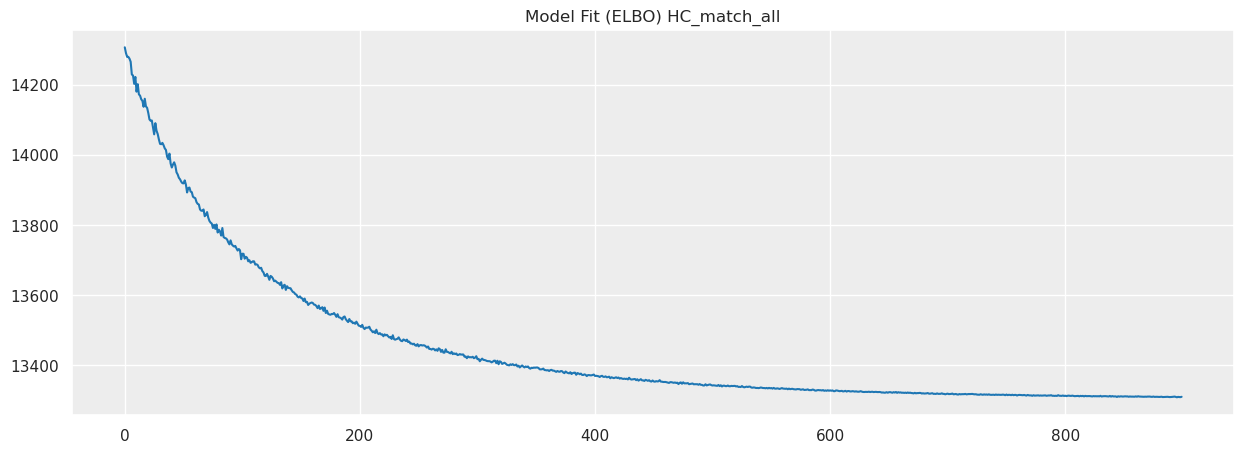

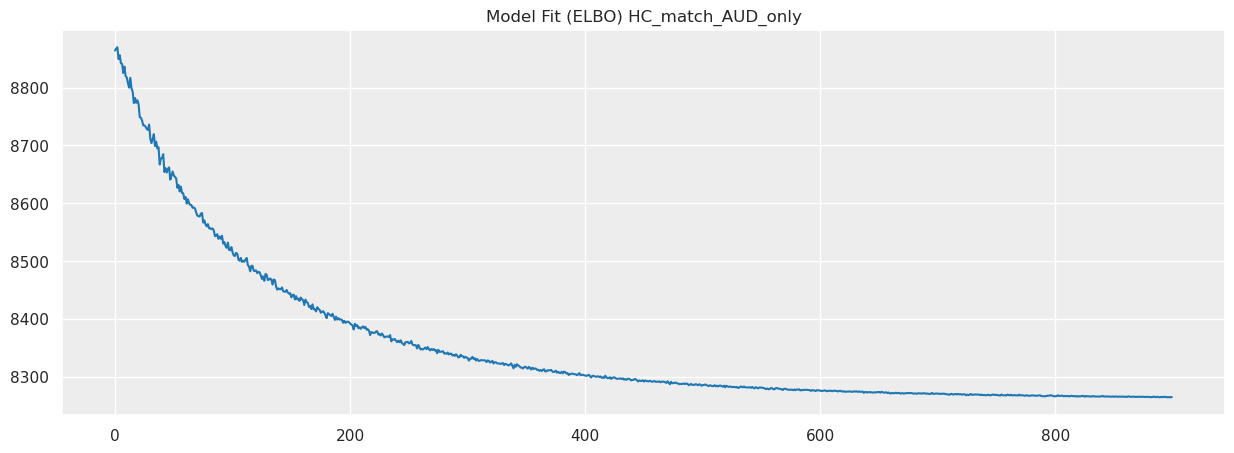

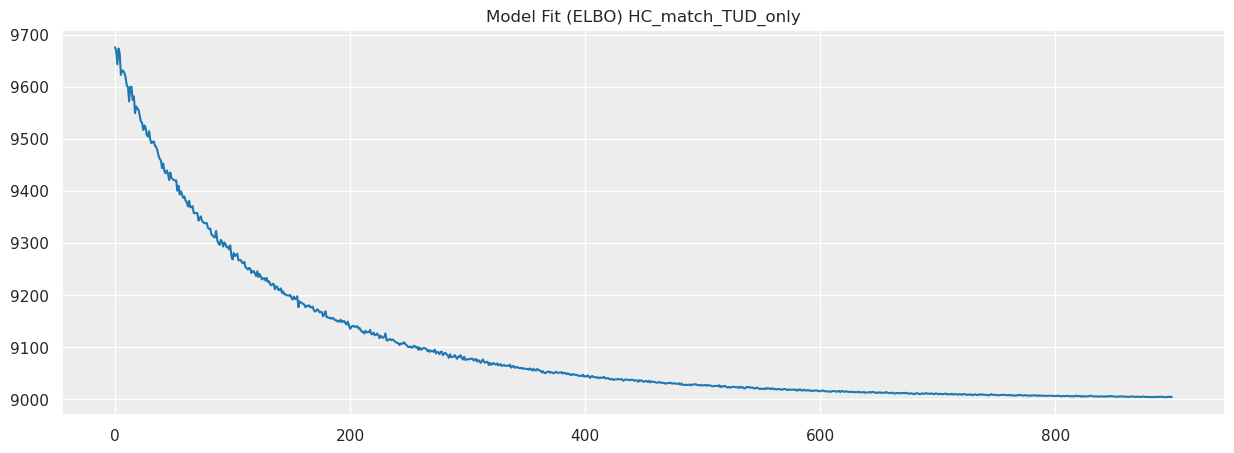

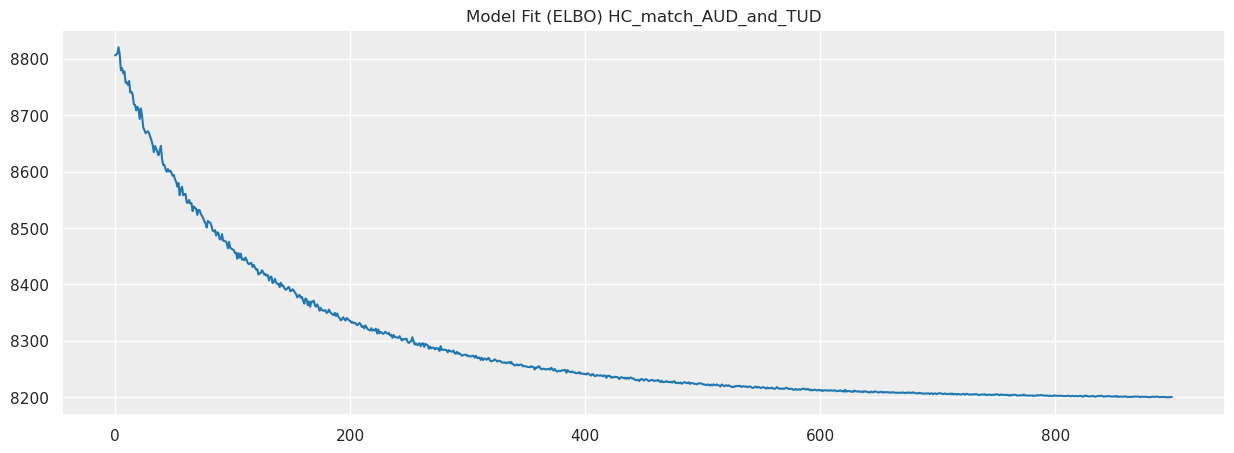

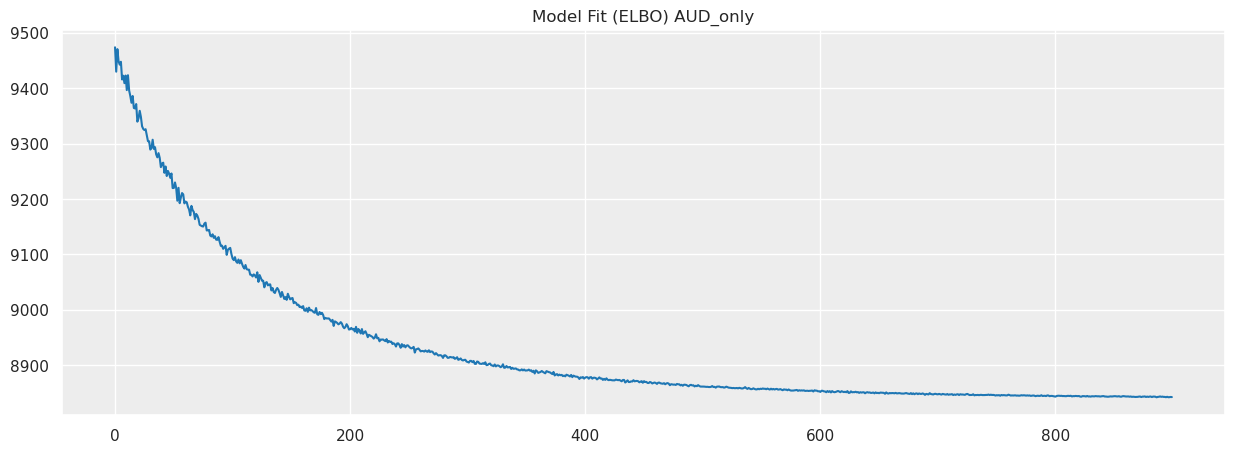

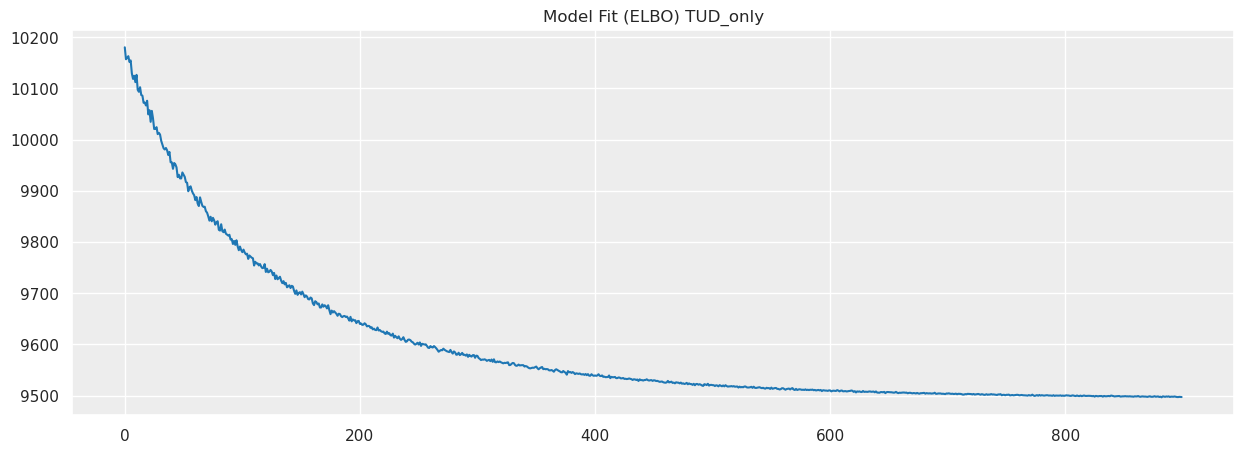

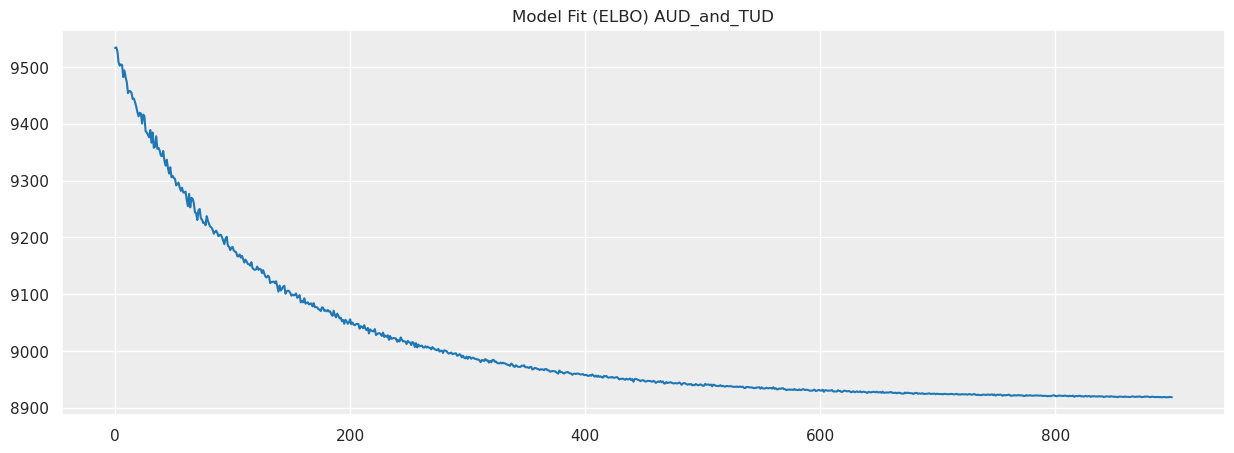

In [16]:
# plot convergence of ELBO bound (approximate value of the negative marginal log likelihood) and stores losses

for i,inf in enumerate([infer_hc_m, infer_hc_m_a, infer_hc_m_t, infer_hc_m_at, infer_aud, infer_tud, infer_aud_tud]):
    fig, axes = plt.subplots(1, 1, figsize=(15, 5))
    axes.plot(inf.loss[100:])  
    axes.set_title('Model Fit (ELBO) '+groups[i])
    fig.savefig(path.join(fitdir, "ELBO_"+groups[i]+".jpg"))

    # store loss
    pd.DataFrame(inf.loss).to_csv(path.join(fitdir,'ELBO_' + groups[i] + '.csv'))

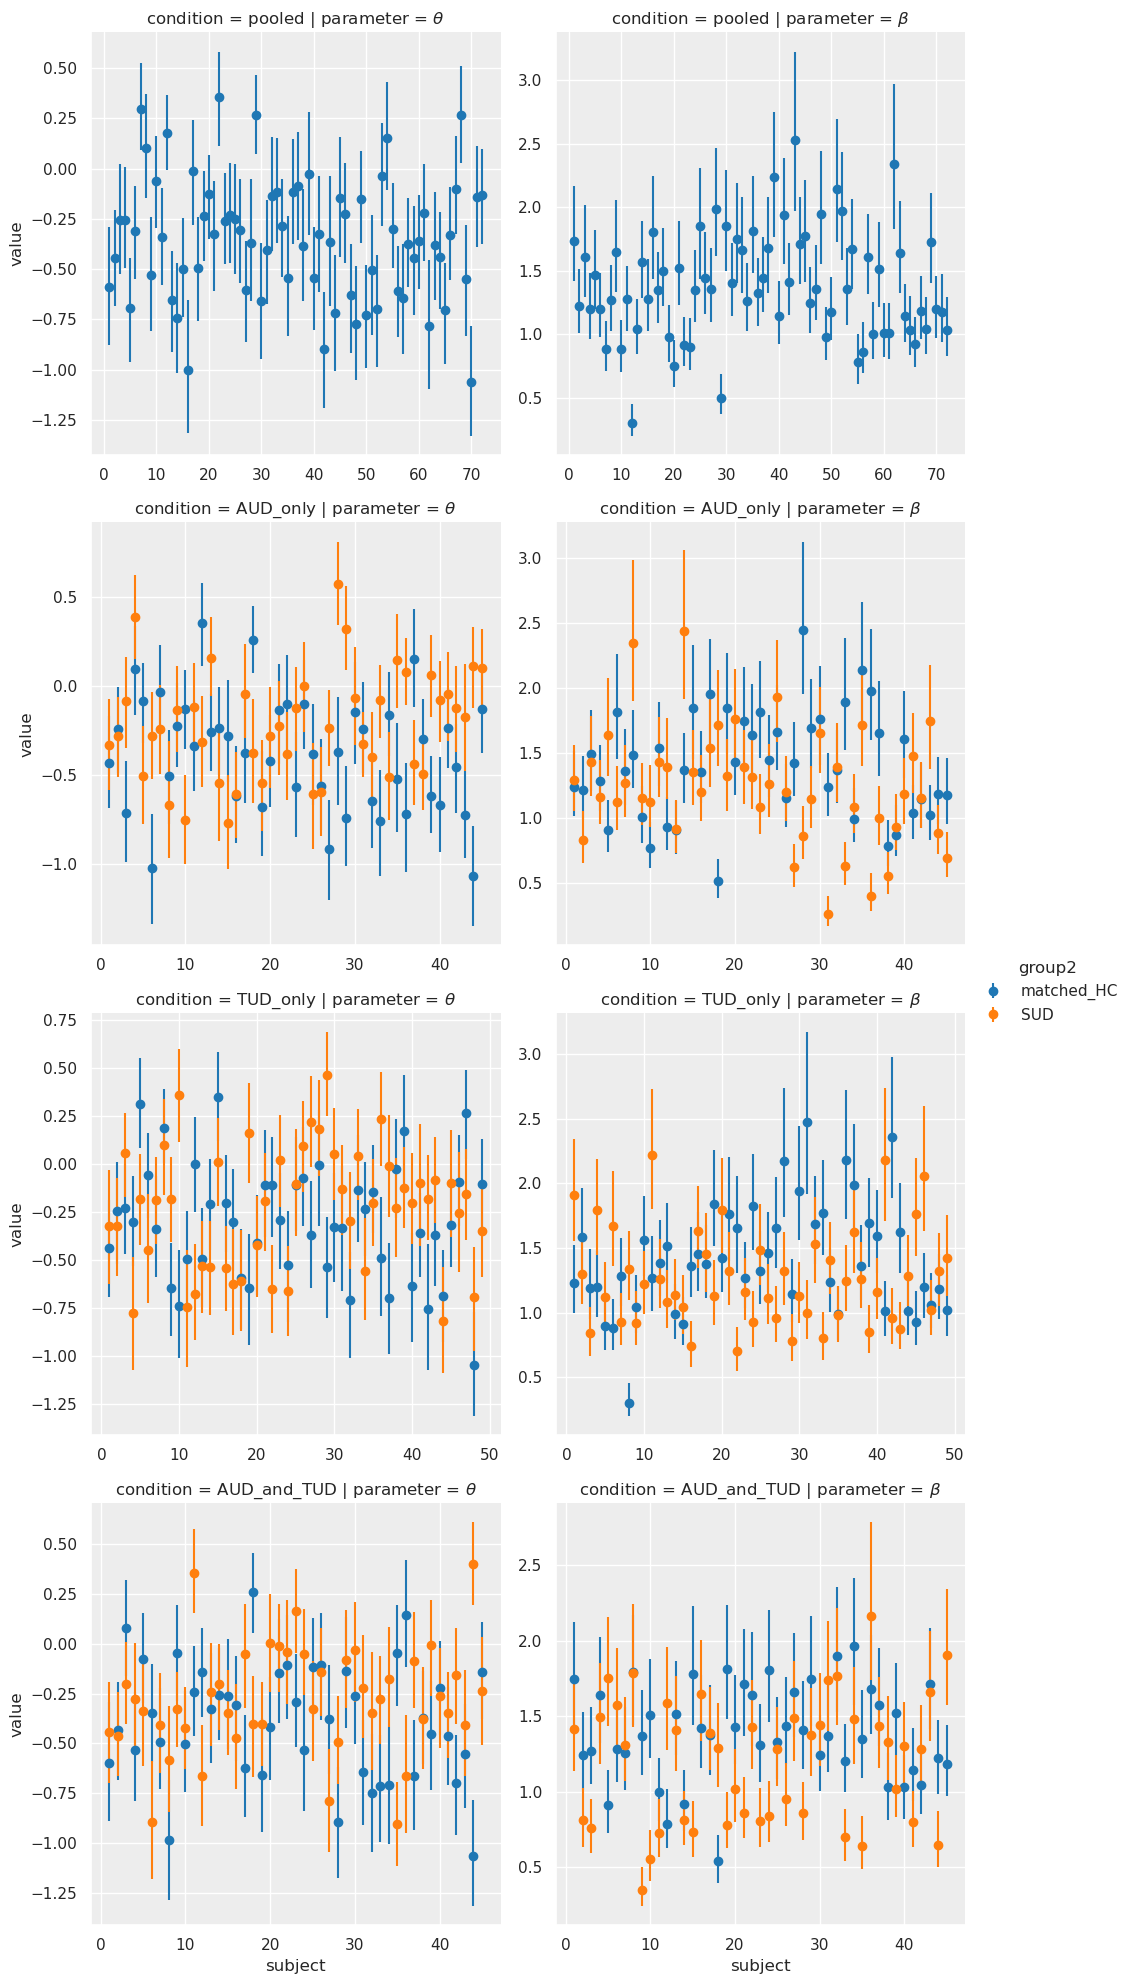

In [17]:
# visualize posterior parameter estimates over subjects
g = sns.FacetGrid(pars_df, col="parameter", hue='group2', row='condition', height=5, sharey=False, sharex=False);
g = g.map(errorplot, 'subject', 'value').add_legend();

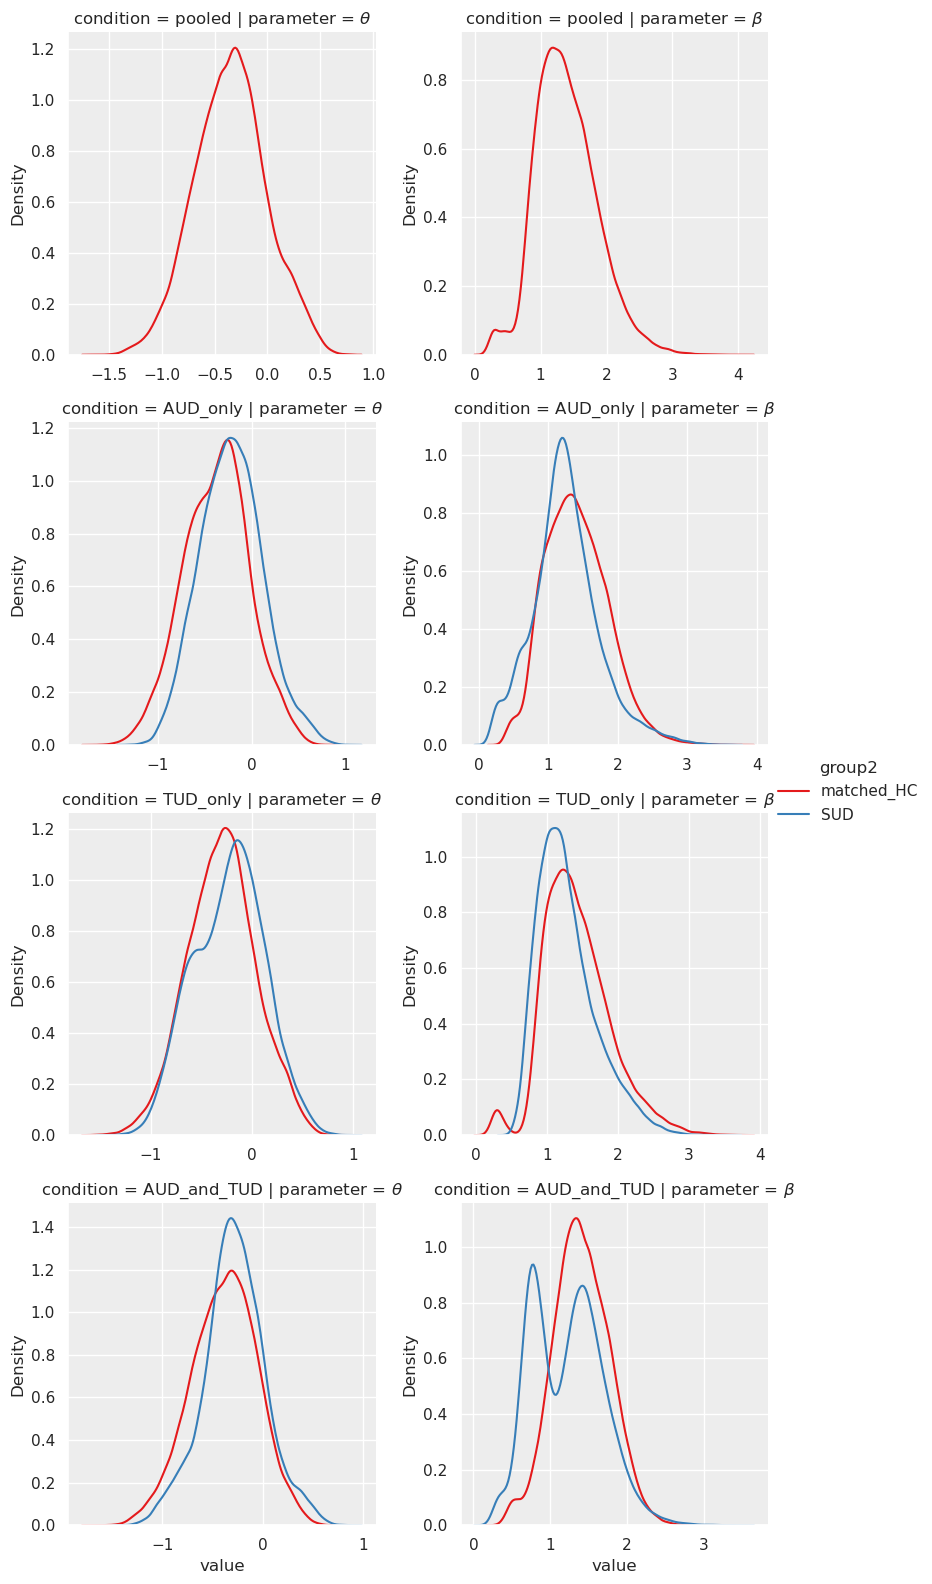

In [18]:
# plot posterior distribution over groups
g = sns.FacetGrid(pars_df, col="parameter", hue='group2', row='condition', height=4, sharey=False, sharex=False, palette='Set1');
g = g.map(sns.kdeplot, 'value').add_legend();

g.figure.savefig(path.join(fitdir,'post_group_parameters.pdf'), dpi=300)

In [19]:
# # load parameter csv file
# pars_df         = pd.read_csv(path.join(fitdir,'pars_post_samples.csv'),         index_col=0, dtype={'ID':object})

# pars_df_hc_m    = pd.read_csv(path.join(fitdir,'pars_post_samples_hc_m.csv'),    index_col=0, dtype={'ID':object})
# pars_df_hc_m_a  = pd.read_csv(path.join(fitdir,'pars_post_samples_hc_m_a.csv'),  index_col=0, dtype={'ID':object})
# pars_df_hc_m_t  = pd.read_csv(path.join(fitdir,'pars_post_samples_hc_m_t.csv'),  index_col=0, dtype={'ID':object})
# pars_df_hc_m_at = pd.read_csv(path.join(fitdir,'pars_post_samples_hc_m_at.csv'), index_col=0, dtype={'ID':object})
# pars_df_aud     = pd.read_csv(path.join(fitdir,'pars_post_samples_aud.csv'),     index_col=0, dtype={'ID':object})
# pars_df_tud     = pd.read_csv(path.join(fitdir,'pars_post_samples_tud.csv'),     index_col=0, dtype={'ID':object})
# pars_df_aud_tud = pd.read_csv(path.join(fitdir,'pars_post_samples_aud_tud.csv'), index_col=0, dtype={'ID':object})

# pars_IDorder_hc_m     = pars_df_hc_m.groupby(   by=['ID','subject']).size().reset_index().subject.to_numpy()
# pars_IDorder_hc_m_a   = pars_df_hc_m_a.groupby( by=['ID','subject']).size().reset_index().subject.to_numpy()
# pars_IDorder_hc_m_t   = pars_df_hc_m_t.groupby( by=['ID','subject']).size().reset_index().subject.to_numpy()
# pars_IDorder_hc_m_at  = pars_df_hc_m_at.groupby(by=['ID','subject']).size().reset_index().subject.to_numpy()
# pars_IDorder_aud      = pars_df_aud.groupby(    by=['ID','subject']).size().reset_index().subject.to_numpy()
# pars_IDorder_tud      = pars_df_tud.groupby(    by=['ID','subject']).size().reset_index().subject.to_numpy()
# pars_IDorder_aud_tud  = pars_df_aud_tud.groupby(by=['ID','subject']).size().reset_index().subject.to_numpy()

# # load inference results from npz
# m_prob_hc_m    = np.load(path.join(fitdir,"plandepth_stats_hc_m.npz"),    allow_pickle=True)['arr_1']
# m_prob_hc_m_a  = np.load(path.join(fitdir,"plandepth_stats_hc_m_a.npz"),  allow_pickle=True)['arr_1']
# m_prob_hc_m_t  = np.load(path.join(fitdir,"plandepth_stats_hc_m_t.npz"),  allow_pickle=True)['arr_1']
# m_prob_hc_m_at = np.load(path.join(fitdir,"plandepth_stats_hc_m_at.npz"), allow_pickle=True)['arr_1']
# m_prob_aud     = np.load(path.join(fitdir,"plandepth_stats_aud.npz"),     allow_pickle=True)['arr_1']
# m_prob_tud     = np.load(path.join(fitdir,"plandepth_stats_tud.npz"),     allow_pickle=True)['arr_1']
# m_prob_aud_tud = np.load(path.join(fitdir,"plandepth_stats_aud_tud.npz"), allow_pickle=True)['arr_1']

In [68]:
# Import Redcap and Covariate data
filepath = glob.glob(path.join(datadir,"redcap_and_covariate_data_preprocessed_*.csv"))[-1]
df_rc = pd.read_csv(filepath, dtype={'ID':'object'}, sep=";")
# drop redundant columns
df_rc.drop(columns=["balancing_index",
                    "SAT_score"], inplace = True)

In [69]:
# create miniblock-wise dfs
mini_blocks = 140
start_points = 350
maximumPossiblePoints = 3150 # max. possible points from 10.000 depth-3 agent simulations (140 mini-blocks incl. starting points)

nsub_hc_m = len(ids_hc_m)
m_prob_hc_m_IDindex = (pars_IDorder_hc_m.repeat(mini_blocks)-1)*mini_blocks + np.tile(np.arange(0,mini_blocks),nsub_hc_m)
sbj_df_hc_m = pd.DataFrame()
sbj_df_hc_m['ID'] = ids_hc_m
sbj_df_hc_m['group'] = groups[0]

mb_df_hc_m = pd.concat([sbj_df_hc_m] * mini_blocks, ignore_index=True).sort_values(by="ID", ignore_index=True)
mb_df_hc_m["block_num"] = np.tile(np.arange(1,mini_blocks+1),nsub_hc_m)
mb_df_hc_m["noise"] = conditions_hc_m[0,:,:].reshape(mini_blocks * nsub_hc_m)
mb_df_hc_m["steps"] = conditions_hc_m[1,:,:].reshape(mini_blocks * nsub_hc_m)
mb_df_hc_m["a0"]    = responses_hc_m[:,:,0].reshape(mini_blocks * nsub_hc_m)
mb_df_hc_m["SAT_RT"] = rts_hc_m[:,:,0].reshape(mini_blocks * nsub_hc_m) / 1000 # convert from ms to seconds
mb_df_hc_m['MeanPD'] = np.matmul(m_prob_hc_m[0], np.arange(1,4)).reshape(mini_blocks * nsub_hc_m, order='F')[m_prob_hc_m_IDindex]
mb_df_hc_m['SAT_keys_condition'] = np.repeat(bal_hc_m.numpy(), mini_blocks).astype(int)
mb_df_hc_m['SAT_Total_points'] = np.repeat(np.array(scores_hc_m[:,-1,-1]),mini_blocks).astype(int)
mb_df_hc_m['SAT_PER'] = mb_df_hc_m['SAT_Total_points'] / maximumPossiblePoints * 100


nsub_hc_m_a = len(ids_hc_m_a)
m_prob_hc_m_a_IDindex = (pars_IDorder_hc_m_a.repeat(mini_blocks)-1)*mini_blocks + np.tile(np.arange(0,mini_blocks),nsub_hc_m_a)
sbj_df_hc_m_a = pd.DataFrame()
sbj_df_hc_m_a['ID'] = ids_hc_m_a
sbj_df_hc_m_a['group'] = groups[1]

mb_df_hc_m_a = pd.concat([sbj_df_hc_m_a] * mini_blocks, ignore_index=True).sort_values(by="ID", ignore_index=True)
mb_df_hc_m_a["block_num"] = np.tile(np.arange(1,mini_blocks+1),nsub_hc_m_a)
mb_df_hc_m_a["noise"] = conditions_hc_m_a[0,:,:].reshape(mini_blocks * nsub_hc_m_a)
mb_df_hc_m_a["steps"] = conditions_hc_m_a[1,:,:].reshape(mini_blocks * nsub_hc_m_a)
mb_df_hc_m_a["a0"]    = responses_hc_m_a[:,:,0].reshape(mini_blocks * nsub_hc_m_a)
mb_df_hc_m_a["SAT_RT"] = rts_hc_m_a[:,:,0].reshape(mini_blocks * nsub_hc_m_a) / 1000 # convert from ms to seconds
mb_df_hc_m_a['MeanPD'] = np.matmul(m_prob_hc_m_a[0], np.arange(1,4)).reshape(mini_blocks * nsub_hc_m_a, order='F')[m_prob_hc_m_a_IDindex]
mb_df_hc_m_a['SAT_keys_condition'] = np.repeat(bal_hc_m_a.numpy(), mini_blocks).astype(int)
mb_df_hc_m_a['SAT_Total_points'] = np.repeat(np.array(scores_hc_m_a[:,-1,-1]),mini_blocks).astype(int)
mb_df_hc_m_a['SAT_PER'] = mb_df_hc_m_a['SAT_Total_points'] / maximumPossiblePoints * 100


nsub_hc_m_t = len(ids_hc_m_t)
m_prob_hc_m_t_IDindex = (pars_IDorder_hc_m_t.repeat(mini_blocks)-1)*mini_blocks + np.tile(np.arange(0,mini_blocks),nsub_hc_m_t)
sbj_df_hc_m_t = pd.DataFrame()
sbj_df_hc_m_t['ID'] = ids_hc_m_t
sbj_df_hc_m_t['group'] = groups[2]

mb_df_hc_m_t = pd.concat([sbj_df_hc_m_t] * mini_blocks, ignore_index=True).sort_values(by="ID", ignore_index=True)
mb_df_hc_m_t["block_num"] = np.tile(np.arange(1,mini_blocks+1),nsub_hc_m_t)
mb_df_hc_m_t["noise"] = conditions_hc_m_t[0,:,:].reshape(mini_blocks * nsub_hc_m_t)
mb_df_hc_m_t["steps"] = conditions_hc_m_t[1,:,:].reshape(mini_blocks * nsub_hc_m_t)
mb_df_hc_m_t["a0"]    = responses_hc_m_t[:,:,0].reshape(mini_blocks * nsub_hc_m_t)
mb_df_hc_m_t["SAT_RT"] = rts_hc_m_t[:,:,0].reshape(mini_blocks * nsub_hc_m_t) / 1000 # convert from ms to seconds
mb_df_hc_m_t['MeanPD'] = np.matmul(m_prob_hc_m_t[0], np.arange(1,4)).reshape(mini_blocks * nsub_hc_m_t, order='F')[m_prob_hc_m_t_IDindex]
mb_df_hc_m_t['SAT_keys_condition'] = np.repeat(bal_hc_m_t.numpy(), mini_blocks).astype(int)
mb_df_hc_m_t['SAT_Total_points'] = np.repeat(np.array(scores_hc_m_t[:,-1,-1]),mini_blocks).astype(int)
mb_df_hc_m_t['SAT_PER'] = mb_df_hc_m_t['SAT_Total_points'] / maximumPossiblePoints * 100


nsub_hc_m_at = len(ids_hc_m_at)
m_prob_hc_m_at_IDindex = (pars_IDorder_hc_m_at.repeat(mini_blocks)-1)*mini_blocks + np.tile(np.arange(0,mini_blocks),nsub_hc_m_at)
sbj_df_hc_m_at = pd.DataFrame()
sbj_df_hc_m_at['ID'] = ids_hc_m_at
sbj_df_hc_m_at['group'] = groups[3]

mb_df_hc_m_at = pd.concat([sbj_df_hc_m_at] * mini_blocks, ignore_index=True).sort_values(by="ID", ignore_index=True)
mb_df_hc_m_at["block_num"] = np.tile(np.arange(1,mini_blocks+1),nsub_hc_m_at)
mb_df_hc_m_at["noise"] = conditions_hc_m_at[0,:,:].reshape(mini_blocks * nsub_hc_m_at)
mb_df_hc_m_at["steps"] = conditions_hc_m_at[1,:,:].reshape(mini_blocks * nsub_hc_m_at)
mb_df_hc_m_at["a0"]    = responses_hc_m_at[:,:,0].reshape(mini_blocks * nsub_hc_m_at)
mb_df_hc_m_at["SAT_RT"] = rts_hc_m_at[:,:,0].reshape(mini_blocks * nsub_hc_m_at) / 1000 # convert from ms to seconds
mb_df_hc_m_at['MeanPD'] = np.matmul(m_prob_hc_m_at[0], np.arange(1,4)).reshape(mini_blocks * nsub_hc_m_at, order='F')[m_prob_hc_m_at_IDindex]
mb_df_hc_m_at['SAT_keys_condition'] = np.repeat(bal_hc_m_at.numpy(), mini_blocks).astype(int)
mb_df_hc_m_at['SAT_Total_points'] = np.repeat(np.array(scores_hc_m_at[:,-1,-1]),mini_blocks).astype(int)
mb_df_hc_m_at['SAT_PER'] = mb_df_hc_m_at['SAT_Total_points'] / maximumPossiblePoints * 100


nsub_aud = len(ids_aud)
m_prob_aud_IDindex = (pars_IDorder_aud.repeat(mini_blocks)-1)*mini_blocks + np.tile(np.arange(0,mini_blocks),nsub_aud)
sbj_df_aud = pd.DataFrame()
sbj_df_aud['ID'] = ids_aud
sbj_df_aud['group'] = groups[4]

mb_df_aud = pd.concat([sbj_df_aud] * mini_blocks, ignore_index=True).sort_values(by="ID", ignore_index=True)
mb_df_aud["block_num"] = np.tile(np.arange(1,mini_blocks+1),nsub_aud)
mb_df_aud["noise"] = conditions_aud[0,:,:].reshape(mini_blocks * nsub_aud)
mb_df_aud["steps"] = conditions_aud[1,:,:].reshape(mini_blocks * nsub_aud)
mb_df_aud["a0"]    = responses_aud[:,:,0].reshape(mini_blocks * nsub_aud)
mb_df_aud["SAT_RT"] = rts_aud[:,:,0].reshape(mini_blocks * nsub_aud) / 1000 # convert from ms to seconds
mb_df_aud['MeanPD'] = np.matmul(m_prob_aud[0], np.arange(1,4)).reshape(mini_blocks * nsub_aud, order='F')[m_prob_aud_IDindex]
mb_df_aud['SAT_keys_condition'] = np.repeat(bal_aud.numpy(), mini_blocks).astype(int)
mb_df_aud['SAT_Total_points'] = np.repeat(np.array(scores_aud[:,-1,-1]),mini_blocks).astype(int)
mb_df_aud['SAT_PER'] = mb_df_aud['SAT_Total_points'] / maximumPossiblePoints * 100


nsub_tud = len(ids_tud)
m_prob_tud_IDindex = (pars_IDorder_tud.repeat(mini_blocks)-1)*mini_blocks + np.tile(np.arange(0,mini_blocks),nsub_tud)
sbj_df_tud = pd.DataFrame()
sbj_df_tud['ID'] = ids_tud
sbj_df_tud['group'] = groups[5]

mb_df_tud = pd.concat([sbj_df_tud] * mini_blocks, ignore_index=True).sort_values(by="ID", ignore_index=True)
mb_df_tud["block_num"] = np.tile(np.arange(1,mini_blocks+1),nsub_tud)
mb_df_tud["noise"] = conditions_tud[0,:,:].reshape(mini_blocks * nsub_tud)
mb_df_tud["steps"] = conditions_tud[1,:,:].reshape(mini_blocks * nsub_tud)
mb_df_tud["a0"]    = responses_tud[:,:,0].reshape(mini_blocks * nsub_tud)
mb_df_tud["SAT_RT"] = rts_tud[:,:,0].reshape(mini_blocks * nsub_tud) / 1000 # convert from ms to seconds
mb_df_tud['MeanPD'] = np.matmul(m_prob_tud[0], np.arange(1,4)).reshape(mini_blocks * nsub_tud, order='F')[m_prob_tud_IDindex]
mb_df_tud['SAT_keys_condition'] = np.repeat(bal_tud.numpy(), mini_blocks).astype(int)
mb_df_tud['SAT_Total_points'] = np.repeat(np.array(scores_tud[:,-1,-1]),mini_blocks).astype(int)
mb_df_tud['SAT_PER'] = mb_df_tud['SAT_Total_points'] / maximumPossiblePoints * 100


nsub_aud_tud = len(ids_aud_tud)
m_prob_aud_tud_IDindex = (pars_IDorder_aud_tud.repeat(mini_blocks)-1)*mini_blocks + np.tile(np.arange(0,mini_blocks),nsub_aud_tud)
sbj_df_aud_tud = pd.DataFrame()
sbj_df_aud_tud['ID'] = ids_aud_tud
sbj_df_aud_tud['group'] = groups[6]

mb_df_aud_tud = pd.concat([sbj_df_aud_tud] * mini_blocks, ignore_index=True).sort_values(by="ID", ignore_index=True)
mb_df_aud_tud["block_num"] = np.tile(np.arange(1,mini_blocks+1),nsub_aud_tud)
mb_df_aud_tud["noise"] = conditions_aud_tud[0,:,:].reshape(mini_blocks * nsub_aud_tud)
mb_df_aud_tud["steps"] = conditions_aud_tud[1,:,:].reshape(mini_blocks * nsub_aud_tud)
mb_df_aud_tud["a0"]    = responses_aud_tud[:,:,0].reshape(mini_blocks * nsub_aud_tud)
mb_df_aud_tud["SAT_RT"] = rts_aud_tud[:,:,0].reshape(mini_blocks * nsub_aud_tud) / 1000 # convert from ms to seconds
mb_df_aud_tud['MeanPD'] = np.matmul(m_prob_aud_tud[0], np.arange(1,4)).reshape(mini_blocks * nsub_aud_tud, order='F')[m_prob_aud_tud_IDindex]
mb_df_aud_tud['SAT_keys_condition'] = np.repeat(bal_aud_tud.numpy(), mini_blocks).astype(int)
mb_df_aud_tud['SAT_Total_points'] = np.repeat(np.array(scores_aud_tud[:,-1,-1]),mini_blocks).astype(int)
mb_df_aud_tud['SAT_PER'] = mb_df_aud_tud['SAT_Total_points'] / maximumPossiblePoints * 100


SAT_singleMiniblocks_df = pd.concat([mb_df_hc_m, mb_df_hc_m_a, mb_df_hc_m_t, mb_df_hc_m_at, mb_df_aud, mb_df_tud, mb_df_aud_tud], axis=0, ignore_index=True)
# add group_id for stats
SAT_singleMiniblocks_df["group_id"] = SAT_singleMiniblocks_df.group.replace(translation_dict).astype("int64").values

# create subject-wise df of model params
pars_df_subj = pd.pivot(pars_df.groupby(["ID","group","group2","condition","parameter"], as_index=False).mean(),index=["ID","subject","group","group2","condition"],columns="parameter", values="value").reset_index().rename_axis(None, axis=1)
pars_df_subj.rename(columns={"$\\beta$":"model_beta","$\\theta$":"model_theta","$k$":"model_k"},inplace=True)

# add params to miniblock-wise dfs
SAT_singleMiniblocks_df = pd.merge(left=SAT_singleMiniblocks_df, right=pars_df_subj, on=['ID','group'])

# add model fits to miniblock-wise dfs
SAT_singleMiniblocks_df = pd.merge(left=SAT_singleMiniblocks_df, right=df_fit, on=['ID','group'])
SAT_singleMiniblocks_df = pd.merge(left=SAT_singleMiniblocks_df, right=df_waic_pointwise, on=['ID','group','block_num'])

# add redcap and covariate data to miniblock-wise dfs
SAT_singleMiniblocks_df = pd.merge(left=SAT_singleMiniblocks_df, right=df_rc.drop(columns=['group', 'SAT_RT']), on='ID')

# create condition-wise df
SAT_conditionLevel_df = SAT_singleMiniblocks_df.groupby(by=['ID','noise','steps', 'group',"group2","condition"], as_index=False).agg(mean_str)
SAT_conditionLevel_df.drop(columns=['block_num'], inplace=True)

# create subject-wise df
SAT_subjectLevel_df = SAT_singleMiniblocks_df.groupby(by=['ID','group',"group2","condition"], as_index=False).agg(mean_str)
SAT_subjectLevel_df.drop(columns=['noise','steps','block_num'], inplace=True)

# store all dfs
SAT_singleMiniblocks_df.to_csv(path.join(fitdir,'SAT_singleMiniblocks.csv'), sep=";", index=False)
SAT_conditionLevel_df.to_csv(path.join(fitdir,'SAT_conditionLevel.csv'), sep=";", index=False)
SAT_subjectLevel_df.to_csv(path.join(fitdir,'SAT_subjectLevel.csv'), sep=";", index=False) 

/tmp/ipykernel_2048399/4098330781.py:134: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  SAT_singleMiniblocks_df["group_id"] = SAT_singleMiniblocks_df.group.replace(translation_dict).astype("int64").values


<Axes: xlabel='condition', ylabel='MeanPD'>

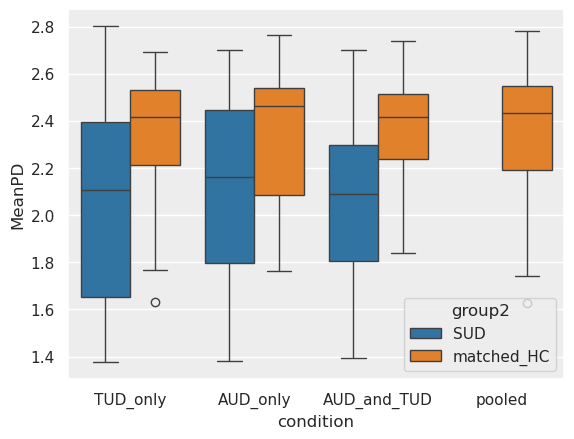

In [22]:
sns.boxplot(SAT_subjectLevel_df, x='condition',y='MeanPD',hue='group2', dodge=True)

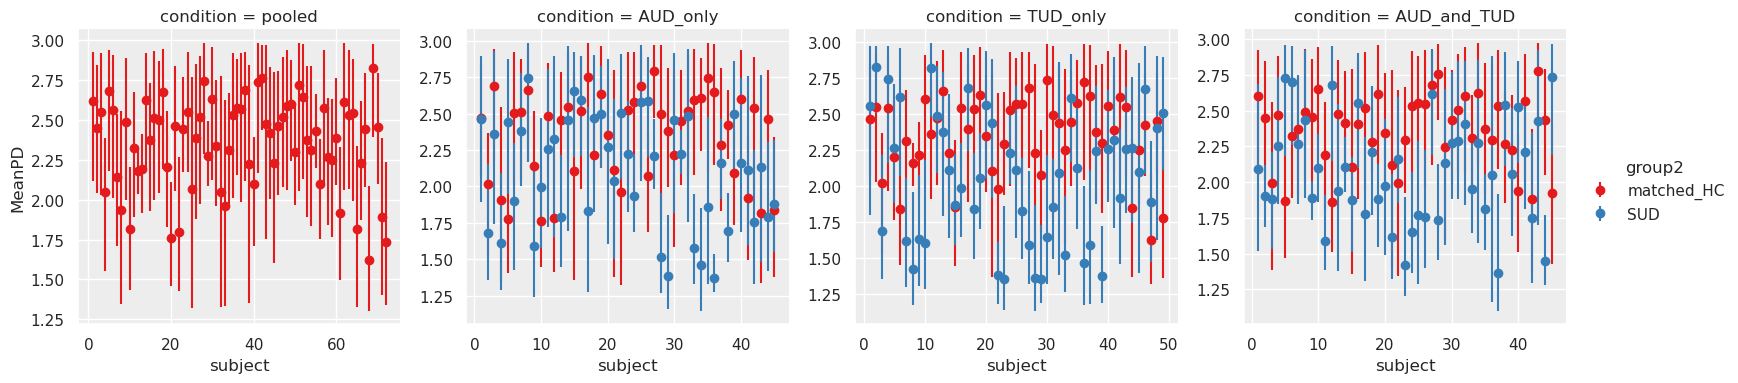

In [23]:
# plot posterior distribution over groups
g = sns.FacetGrid(SAT_singleMiniblocks_df.sort_values(by=['block_num','subject']), col="condition", hue='group2', height=4, sharey=False, sharex=False, palette='Set1');
g = g.map(errorplot, 'subject', 'MeanPD').add_legend();
# errorplot plots median and 5.-to-95.-percentil as bar
g.figure.savefig(path.join(fitdir,'post_group_depths.pdf'), dpi=300)

# TODO: arrange matched subject pairs next to each other

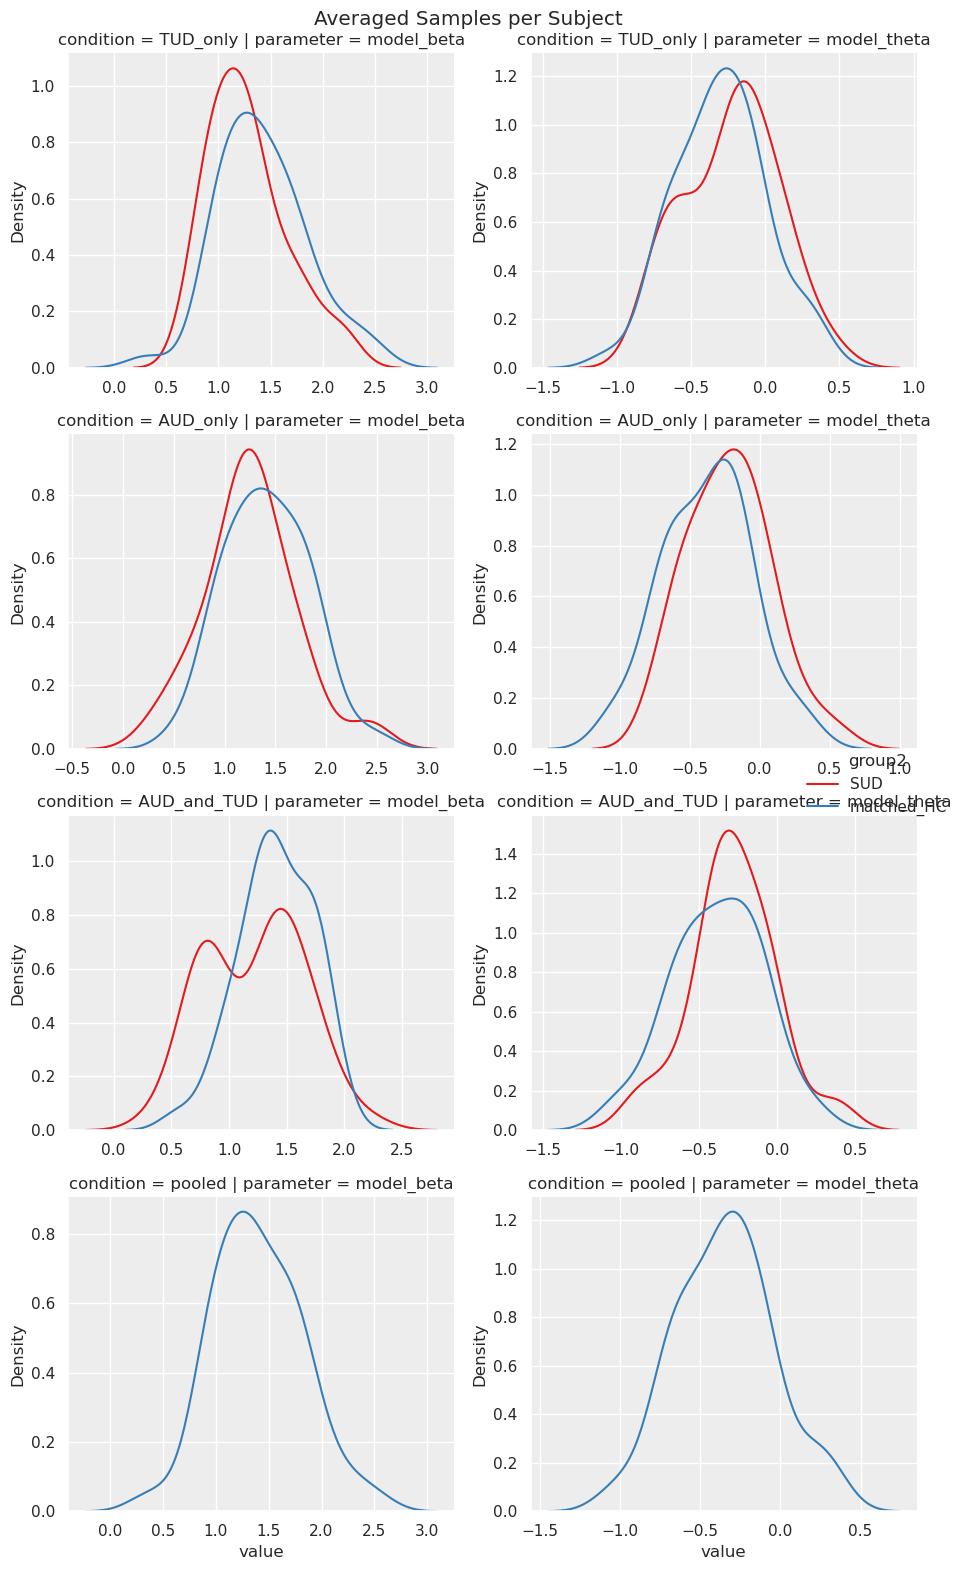

In [24]:
g = sns.FacetGrid(pd.melt(pars_df_subj, id_vars=["ID","subject","group","group2","condition"], value_vars=['model_beta', 'model_theta'], var_name="parameter", value_name="value").reset_index(), hue='group2', col="parameter", row='condition', height=4, sharey=False, sharex=False, palette='Set1');
g = g.map(sns.kdeplot, 'value').add_legend();

g.fig.suptitle("Averaged Samples per Subject");

plt.tight_layout()